# Finding Duplicates among the given images.

This notebook finds duplicate images among a set of images. To do this the image is first passed through a deep learning network (in this example VGG16) to get the features of the image as a vector. Then the vector are compared for similarity with each other to find the duplicates.

For finding the similarity doing a search over all images would take very long if the dataset is large. So we use a package [annoyindex](https://github.com/spotify/annoy) which implements a similarity search using [Localicty Sensitivity Hashing (LSH)](https://en.wikipedia.org/wiki/Locality-sensitive_hashing). LSH works by first finding hash code for each of the image. A hash code is found by making multiple random hyperplanes on the dimension of image vector and hash code is given by the sides of each hyperplane a particular data point lies. This works on the intuition that on high dimensional space similar objects will have similar location on the space.

Once the hash for all the images are found a particular image is tested for similarity only with images having same hash code. This allows the search for duplicate to be done much quicker.

In [1]:
import keras, tensorflow, sys
keras.__version__, tensorflow.__version__, sys.version

Using TensorFlow backend.


('2.2.4',
 '1.11.0',
 '3.6.6 |Anaconda, Inc.| (default, Jun 28 2018, 11:27:44) [MSC v.1900 64 bit (AMD64)]')

Used for training on 2nd GPU in a multi-GPU environment.

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1" 

## Import packages

Import different packages for handling images and building the keras model.

In [3]:
import numpy as np
import cv2
import time
import random
from glob import glob

from keras.applications import VGG16
from keras.preprocessing import image
from keras.applications import vgg16
from keras.models import Model

from annoy import AnnoyIndex

from matplotlib import pyplot as plt
%matplotlib inline

## Dataset

The dataset is taken from the [link](http://www.robots.ox.ac.uk/~vgg/data/pets/?source=post_page---------------------------). Only the images are requried for this notebook.

In [4]:
# Loading the path for each image. 
image_files = glob("./images/*.jpg")
len(image_files)

7390

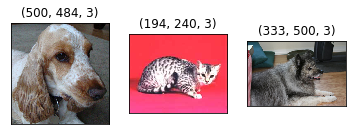

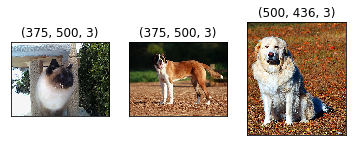

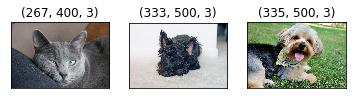

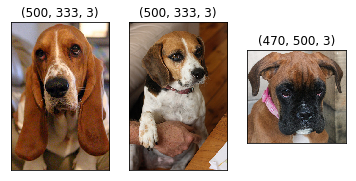

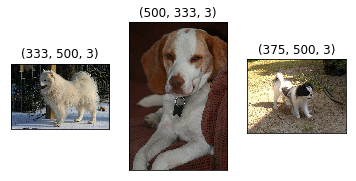

In [5]:
# Loading and viewing some of the images which are chosen at random
ran = random.sample(image_files, 15)
for i in range(0,len(ran),3):
    image = cv2.imread(ran[i],1)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.grid(),plt.subplot(131),plt.imshow(image)
    plt.title(image.shape), plt.xticks([]), plt.yticks([])
    image = cv2.imread(ran[i+1],1)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.grid(),plt.subplot(132),plt.imshow(image)
    plt.title(image.shape), plt.xticks([]), plt.yticks([])
    image = cv2.imread(ran[i+2],1)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.grid(),plt.subplot(133),plt.imshow(image)
    plt.title(image.shape), plt.xticks([]), plt.yticks([])
    plt.show()

## Using VGG16 model to get the image vectors. 

VGG model is loaded from the keras api and the model is configured to produce the output of the second last layer which is a fully-connected layer with output dimesnion of 4096. 

In [6]:
model = VGG16(weights='imagenet')
model = Model(inputs=model.input, outputs=model.get_layer("fc2").output)

## Creating annoyindex object for hashing

In [7]:
f = 4096 # dimension of image vector that will be indexed
t = AnnoyIndex(f)  

Loading each of the images in the folder and after preprocessing the images for VGG network images are passed to the network and the image vector produced is saved as a npy file for further use. The vectors are also added to the Annoyindex for finding the duplicates.

In [8]:
for i in range(len(image_files)):
    try:
        name = image_files[i].split("\\")[-1][:-4]
        image = cv2.imread(image_files[i],1)
        image = cv2.resize(image,(224,224))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = image.reshape((1,224,224,3))
        image = vgg16.preprocess_input(image)
        image = model.predict(image)
        np.save("./image_vectors/"+name, image[0])
        t.add_item(i, image[0])
    except:
        continue

In [9]:
# building tree for Annoy
t.build(100) # 100 trees

True

## Creating the dcitionary containing duplicates.

Iterate over each of the image and load the image vector which was saved earlier. Then find 5 closest vectors to the current vector and return there distance, image name. If the distance is 0 between 2 images, add them as dupliacte to the dictionary.

In [10]:
ret = {}
for n in range(len(image_files)):
    try:
        name = image_files[n].split("\\")[-1][:-4]
        image = np.load("./image_vectors/"+name+".npy")
        nimg, ndist = t.get_nns_by_vector(image, 5, include_distances=True)     
        # (i!=n) is for not considering itself as duplicate. 
        ret[name] = [(image_files[i].split("\\")[-1][:-4], ndist[j]) for j,i in enumerate(nimg) if (ndist[j]==0) & (i!=n)]
        # Remove the key if it does not have any dupliactes
        if len(ret[name])==0:
            del ret[name]
    except:
        continue
    
# save the dictionary as npy file
np.save("./ret_100.npy", ret)

## Results

Viewing some of the images from dictionary key/ value pairs. Leftmost image is the key and the remaining are the duplicates of that image. 

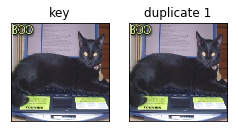

Bombay_206 [('Bombay_109', 0.0)]


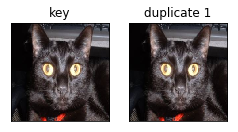

Bombay_198 [('Bombay_69', 0.0)]


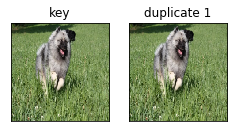

keeshond_59 [('keeshond_54', 0.0)]


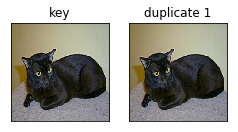

Bombay_126 [('Bombay_220', 0.0)]


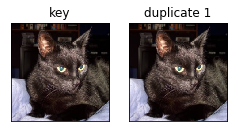

Bombay_217 [('Bombay_131', 0.0)]


In [11]:

ran = random.sample(list(ret), 5)
for i in ran:
        image = cv2.imread("./images/"+i+".jpg",1)
        image = cv2.resize(image,(224,224))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.grid(),plt.subplot(131),plt.imshow(image)
        plt.title("key"), plt.xticks([]), plt.yticks([])
        if len(ret[i])>0:
            image = cv2.imread("./images/"+ret[i][0][0]+".jpg",1)
            image = cv2.resize(image,(224,224))
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            plt.grid(),plt.subplot(132),plt.imshow(image)
            plt.title("duplicate 1"), plt.xticks([]), plt.yticks([])
        
        if len(ret[i])>1:
            image = cv2.imread("./images/"+ret[i][1][0]+".jpg",1)
            image = cv2.resize(image,(224,224))
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            plt.grid(),plt.subplot(133),plt.imshow(image)
            plt.title("duplicate 2"), plt.xticks([]), plt.yticks([])
        plt.show()
        print(i, ret[i])
    